# Rebalancing Portfolio Weights based on MPT

Academic/educational purposes only.  For me to practice coding.

This notebook compares rebalancing strategies for a portfolio containing 5 stocks with ticker symbols AAPL, AMZN, GOOG, FB, and TSLA.  There was no particular reason for choosing these select stocks - they are simply used for demonstration.  Because of this, it is important to mention that rebalancing strategies may differ depending on the composition of the portfolio as well as the selection of asset classes, but this document serves as an exercise (for me) to understand how a portfolio will react in different rebalancing situations.

### Data Reading and Processing

We first read in the data from yahoo finance using the pandas_datareader package.  In this document we use the closing prices for each stock

In [1]:
import pandas_datareader.data as web
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import date
from scipy.stats.mstats import gmean

We define two functions, one that computes the returns data for a given stock name and another that performs the portfolio analysis.  The portfolio analysis takes a dataset of returns, and computes the optimal risky portfolio by randomly generating weights and selecting the best performing porftolio (in terms of the Sharpe Ratio).  The parameters for this dataset are dataset (the returns data), w_inits (how many randomly generated weights to try), risk_free (the simulated risk free rate), and plot (plots the efficient frontier).  

In [2]:
def returns_data(ticker):
    time_series = web.DataReader(ticker,'yahoo', start = '2016-01-01', end = date.today())
    returns = time_series.shift(-1)["Close"]/time_series["Close"] - 1
    return returns.dropna()

def portfolio_analytics(dataset, w_inits, risk_free = 0.03, plot = False):
    
    annual_returns = dataset.mean()*252
    annual_covar = dataset.cov()
    
    tbill = risk_free
    
    er = []
    stdevs = []
    sr = []
    weights = []
    
    for rand_inits in range(0,w_inits):
        
        init_w = np.random.random(len(dataset.columns))
        scaled_w = init_w/np.sum(init_w)
        weights.append(scaled_w)
        
        expected_return = scaled_w @ annual_returns
        std = np.sqrt(np.matmul(np.transpose(scaled_w), np.matmul(annual_covar, scaled_w))) * np.sqrt(252)
        
        er.append(expected_return)
        stdevs.append(std)
        sr.append((expected_return - tbill) / std)
    
    max_sr = np.argmax(sr)
    
    if plot == True:
        plt.figure(figsize = (10,8))
        plt.scatter(stdevs,er)
        plt.ylabel("Expected Return")
        plt.xlabel("Standard Deviation")
        plt.title("Efficient Frontier")
        plt.scatter(stdevs[max_sr],er[max_sr], c = "red", s = 500, marker = (5,1))

    return sr[max_sr], weights[max_sr]

We use log returns to compute the optimal weights, but use the original returns to plot our data.

In [3]:
symbols = ["AAPL","AMZN","GOOG","FB","TSLA"]

sharpe_ratios = []
rf = 0.03

returns = pd.DataFrame()
log_returns = pd.DataFrame()

for symbol in symbols:
    returns[symbol] = returns_data(symbol)
    log_returns[symbol] = returns[symbol].apply(lambda x: np.log(1+x))

In [8]:
returns.corr()

,AAPL,AMZN,GOOG,FB,TSLA
AAPL,1.000000,0.597360,0.645295,0.577423,0.396430
AMZN,0.597360,1.000000,0.656533,0.615494,0.368968
GOOG,0.645295,0.656533,1.000000,0.684274,0.361621
FB,0.577423,0.615494,0.684274,1.000000,0.325117
TSLA,0.396430,0.368968,0.361621,0.325117,1.000000


Unsurprisingly, most of these stocks are highly correlated to one another, as they generally all operate in similar industries (particularly, AI/Machine Learning). 

Below is the use of the portfolio_analytics function with plot = True.  The Optimal Risky Portfolio is highlighted with a red star.  In this particular run, we do not rebalance weights at all throughout the time period starting from 2016-01-01.  We can think of this portfolio as starting from the optimal weights, and holding them throughout the rest of the dataset.

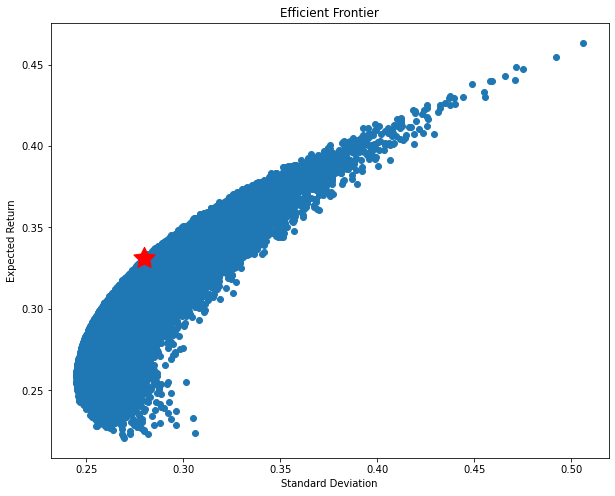

In [4]:
sr, weights = portfolio_analytics(log_returns, 50000, plot = True)
sharpe_ratios.append(sr)

We can simulate a portfolio of 100000 dollars and observe its growth over time using the optimal weights found in the previous cell.  We also assume implicitly that we can buy fractional shares, and that there are no transaction costs of buying securities (we don't sell since we don't rebalance). 

In [5]:
portfolio_value = 100000
time_series = [portfolio_value]

for i in range(len(returns)):
    portfolio_value *= 1 + weights @ np.transpose(returns.iloc[i])
    time_series.append(portfolio_value)

Text(0.5, 1.0, 'Optimal Weights with all Historical Data')

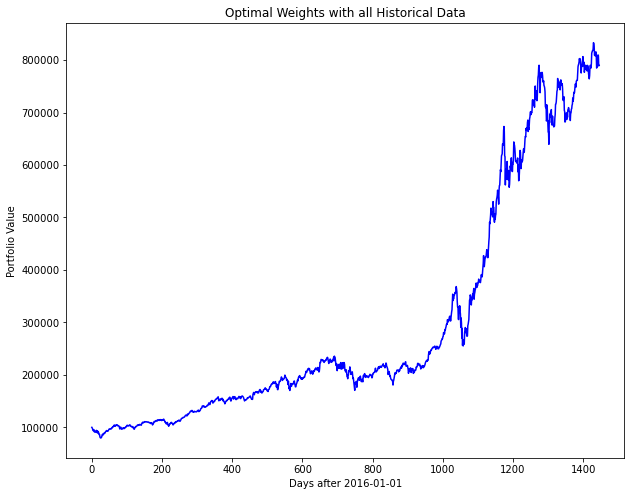

In [6]:
plt.figure(figsize = (10,8))
plt.plot(time_series, c = "b")
plt.xlabel("Days after 2016-01-01")
plt.ylabel("Portfolio Value")
plt.title("Optimal Weights with all Historical Data")

Our initial investment grew almost 8 times in the span of 5 years - however, before we celebrate, we must remember that this is simply because we're running the optimization on historical data.  If you've ever seen Back to the Future Part 2, this is something like making bets with a sports manual from the future.  

### Yearly Rebalancing

We now rebalance every year.  The process is as follows: we first initialize a set of weights by sampling 1000 days of returns data from our log returns dataset.  Then, for each time period $t$, we compute the optimal weights for the portfolio using the log returns data for time period $t$, and then hold these weights through time period $t+1$.  Then, at the end of time period $t+1$, we rebalance our weights using the log returns data for time period $t+1$, and then hold them constant through time period $t+2$, and so on and so forth.

The first strategy is to rebalance yearly.  Again, we assume that there are no transaction costs, which is impractical in reality.

In [200]:
log_returns["Year"] = log_returns.index.year
returns["Year"] = returns.index.year

year_groups = log_returns.groupby(by = "Year")

In [201]:
_ , weights = portfolio_analytics(log_returns.drop("Year", axis = 1).sample(1000), 10000)

weights_list = [weights]

for _ , subset in year_groups:
    
    subset.drop("Year",axis = 1, inplace = True)
    
    _ , weights = portfolio_analytics(subset, 10000)
    weights_list.append(weights)

In [202]:
year_groups = returns.groupby(by = "Year")

In [203]:
portfolio_value = 100000
time_series = [portfolio_value]

ind = 0

for _, subset in year_groups:
    
    weights = weights_list[ind]
    
    for i in range(len(subset)):
        portfolio_value *= 1 + weights @ np.transpose(subset.drop("Year", axis = 1).iloc[i])
        time_series.append(portfolio_value)
    
    ind += 1

In [204]:
pct_changes = [(time_series[i] - time_series[i-1])/time_series[i-1] for i in range(1,len(time_series))]
strategy_return = (gmean([1 + x for x in pct_changes]) - 1) * 252
sharpe_ratios.append((strategy_return - rf) / (np.std(pct_changes)*np.sqrt(252)))

Text(0.5, 1.0, 'Yearly Rebalancing')

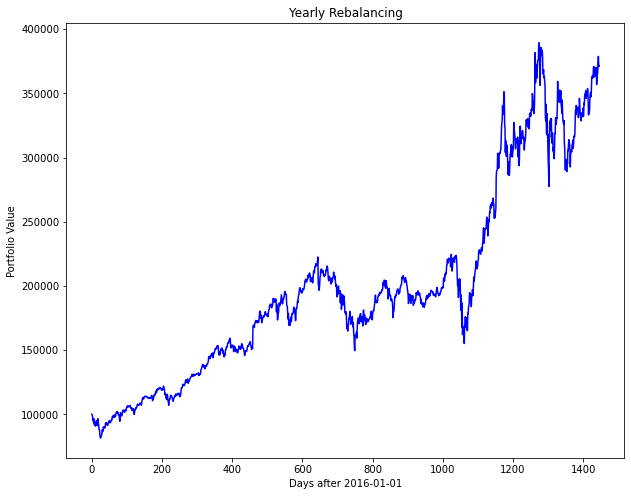

In [205]:
plt.figure(figsize = (10,8))
plt.plot(time_series, c = "b")
plt.xlabel("Days after 2016-01-01")
plt.ylabel("Portfolio Value")
plt.title("Yearly Rebalancing")

It's clear that this strategy underperforms the complete historical ORP, as the return on a 100000 intial investment is significantly less, with seemingly higher amounts of volatility (as seen by the variance of the line).  

### Quarterly Rebalancing

We next rebalance every quarter.  The quarters are defined as Q1 = January, February, March; Q2 = April, May, June; Q3 = July, August, September; Q4 = October, November, December.

In [206]:
log_returns["Month"] = log_returns.index.month
returns["Month"] = returns.index.month

quarters = {1:1, 2:1, 3:1, 4:2, 5:2, 6:2, 7:3, 8:3, 9:3, 10:4, 11:4, 12:4}

log_returns["Q"] = ["Q" + str(quarters[i]) for i in log_returns["Month"]]
returns["Q"] = ["Q" + str(quarters[i]) for i in returns["Month"]]

log_returns["Q"] = log_returns["Year"].map(str) + "-" + log_returns["Q"]
returns["Q"] = returns["Year"].map(str) + "-" + returns["Q"]

q_groups = log_returns.groupby(by = "Q")

In [207]:
_ , weights = portfolio_analytics(log_returns.drop(["Year","Month","Q"], axis = 1).sample(1000), 5000)

weights_list = [weights]

for _ , subset in q_groups:
    
    subset.drop(["Year","Month","Q"],axis = 1, inplace = True)
    _ , weights = portfolio_analytics(subset, 5000)
    weights_list.append(weights)

In [208]:
portfolio_value = 100000
time_series = [portfolio_value]

ind = 0

for _, subset in q_groups:
    
    weights = weights_list[ind]
    
    for i in range(len(subset)):
        portfolio_value *= 1 + weights @ np.transpose(subset.drop(["Year","Month","Q"], axis = 1).iloc[i])
        time_series.append(portfolio_value)

    ind += 1

In [209]:
pct_changes = [(time_series[i] - time_series[i-1])/time_series[i-1] for i in range(1,len(time_series))]
strategy_return = (gmean([1 + x for x in pct_changes]) - 1) * 252
sharpe_ratios.append((strategy_return - rf) / (np.std(pct_changes)*np.sqrt(252)))

Text(0.5, 1.0, 'Quarterly Rebalancing')

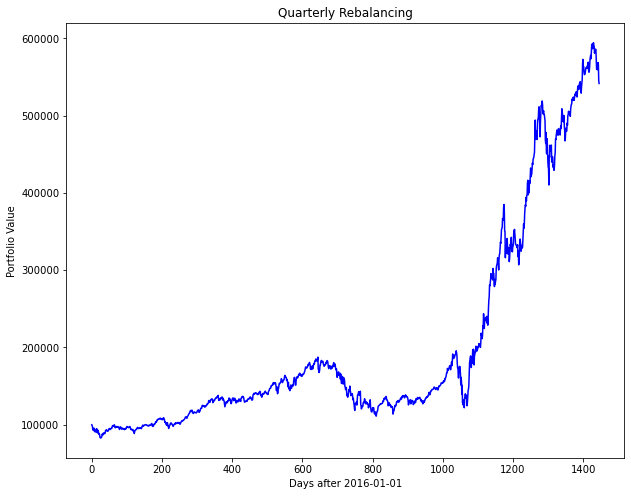

In [210]:
plt.figure(figsize = (10,8))
plt.plot(time_series, c = "b")
plt.xlabel("Days after 2016-01-01")
plt.ylabel("Portfolio Value")
plt.title("Quarterly Rebalancing")

This strategy seems to perform better (again, on our selection of stocks and our particular portfolio) than the yearly rebalancing, given the higher return and a more stable movement across time.

### Monthly Rebalancing

We also observe the effects of rebalancing every month.

In [211]:
log_returns["YM"] = log_returns["Year"].map(str) + "-" + log_returns["Month"].map(str)
returns["YM"] = returns["Year"].map(str) + "-" + returns["Month"].map(str)

m_groups = log_returns.groupby(by = "YM")

In [212]:
_ , weights = portfolio_analytics(log_returns.drop(["YM","Year","Month","Q"], axis = 1).sample(1000), 500)

weights_list = [weights]

for _ , subset in m_groups:
        subset.drop(["YM","Year","Month","Q"],axis = 1, inplace = True)
        _ , weights = portfolio_analytics(subset, 500)
        weights_list.append(weights)

In [213]:
portfolio_value = 100000
time_series = [portfolio_value]

ind = 0

for _, subset in m_groups:
    
    weights = weights_list[ind]
    
    for i in range(len(subset)):
        portfolio_value *= 1 + weights @ np.transpose(subset.drop(["YM","Year","Month","Q"], axis = 1).iloc[i])
        time_series.append(portfolio_value)

    ind += 1

In [214]:
pct_changes = [(time_series[i] - time_series[i-1])/time_series[i-1] for i in range(1,len(time_series))]
strategy_return = (gmean([1 + x for x in pct_changes]) - 1) * 252
sharpe_ratios.append((strategy_return - rf) / (np.std(pct_changes)*np.sqrt(252)))

Text(0.5, 1.0, 'Monthly Rebalancing')

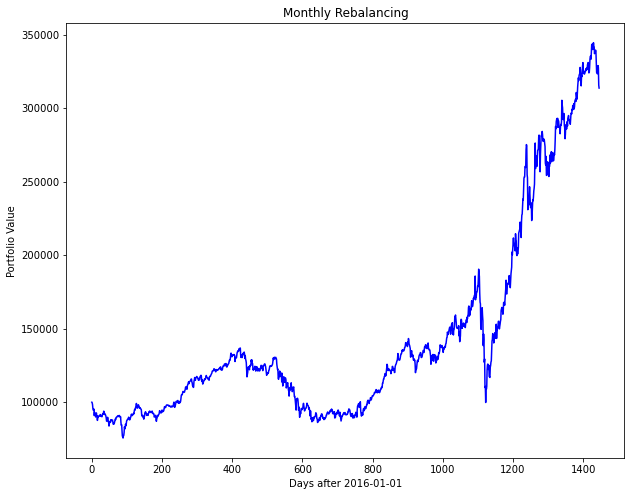

In [215]:
plt.figure(figsize = (10,8))
plt.plot(time_series, c = "b")
plt.xlabel("Days after 2016-01-01")
plt.ylabel("Portfolio Value")
plt.title("Monthly Rebalancing")

The monthly rebalancing strategy seems to underperform all other strategies.

## Comparisons

Based on the findings, we can see that the Quarterly rebalancing strategy is the optimal frequency (excluding the historical ORP), as it maximizes the Sharpe Ratio compared to other frequencies.  There could be several competing reasons as for why this is the case, but if I were to guess, I would assume that too infrequent/frequent rebalancing can lead to missed timings in the market, causing greater losses or missed opportunities to capture returns - again, for these select stocks.  I would argue that quarterly rebalancing finds a nice spot, since it aligns well with economic reports (e.g. company financials or things like GDP).

In [216]:
tbl = pd.DataFrame(index = ["Historical ORP", "Yearly Rebalancing", "Quarterly Rebalancing", "Monthly Rebalancing"])

tbl["SR"] = sharpe_ratios
tbl

,SR
Historical ORP,1.078163
Yearly Rebalancing,0.660873
Quarterly Rebalancing,0.826569
Monthly Rebalancing,0.580605
